# Cosmic shear with Einstein ring simulations

This notebook provides test cases for the precision and accuracy of recovering the cosmic shear from realistic Einstein ring strong gravitational lenses, for the publication: "Cosmic Shear with Einstein Rings", 
[Birrer et al. 2017](https://ui.adsabs.harvard.edu/abs/2018ApJ...852L..14B/abstract).
This notebook requires standard python libraries and the publicly available packages on github:
- lenstronomy (https://github.com/sibirrer/lenstronomy)


For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## simulation choices

In [2]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
kwargs_spemd = {'theta_E': .66, 'gamma': 1.95, 'center_x': 0.05, 'center_y': 0, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
lens_model_list = ['EPL', 'SHEAR', 'SHEAR']
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.1}  # shear values to the source plane
kwargs_foreground = {'gamma1': 0.0, 'gamma2':-0.02}  # non-linear shear values to the lens plane
lens_redshift_list=[0.5, 0.5, 0.1]
z_source = 2
kwargs_lens = [kwargs_spemd, kwargs_shear, kwargs_foreground]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list, lens_redshift_list=lens_redshift_list, z_source=z_source, multi_plane=True)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

beta_model = 0.01  # choice of source size in the input simulation (units of arc seconds)
shapelet_beta = 0.01  # choice of initial shapelet scale in the reconstruction in the lens modelling
n_max_sim = 10  # choice of polynomial order in the shapelet reconstruction in the lens modelling

# Sersic parameters in the initial simulation
kwargs_sersic = {'amp': 1600, 'R_sersic': 0.015, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0., 'center_y': 0}

if source_type == 'SERSIC':
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source = [kwargs_sersic]
elif source_type == 'SHAPELETS':
    source_model_list = ['SHAPELETS']
    kwargs_source = [kwargs_shapelet]
else:
    raise ValueError("Not valid source_type variable!")

from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)
# for this example, we ignore the presence of deflector light
lens_light_model_list = []
kwargs_lens_light_list = []


In [3]:
# import main simulation class of lenstronomy
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, source_model_class=source_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


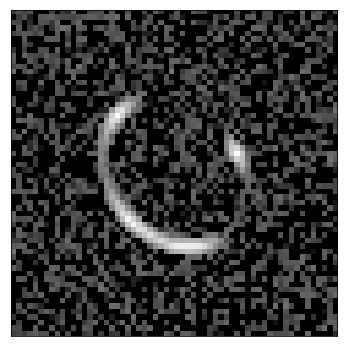

In [4]:
# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [5]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .0001, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.1
                    , 'center_x': 0.0001, 'center_y': 0.0001})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_foreground)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

for i, model in enumerate(source_model_list):
    if model == 'SHAPELETS':
        fixed_source.append({'n_max': n_max_sim})
        kwargs_source_init.append(kwargs_shapelet)
        kwargs_source_sigma.append({'center_x': 0.001, 'center_y': 0.001, 'beta': shapelet_beta/100., 'n_max': 2})
        kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.001, 'n_max': 0})
        kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': 10, 'n_max': 55})
    if model == 'SERSIC_ELLIPSE':
        fixed_source.append({})
        kwargs_source_init.append(kwargs_sersic)
        kwargs_source_sigma.append({'n_sersic': 0.001, 'R_sersic': 0.001, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.0001, 'center_y': 0.0001})
        kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
        kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params}


In [6]:
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 
                'lens_redshift_list': lens_redshift_list, 'z_source': z_source, 'multi_plane': True}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 500, 'n_run': 500, 'walkerRatio': 10, 'sigma_scale': 1.}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

100%|██████████| 1000/1000 [06:47<00:00,  2.46it/s]

Computing the MCMC...
Number of walkers =  160
Burn-in iterations:  500
Sampling iterations (in current run): 1000
407.6106712818146 time taken for MCMC sampling


## analyse MCMC chain

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:118: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


-0.9853958319446132 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9853958319446133


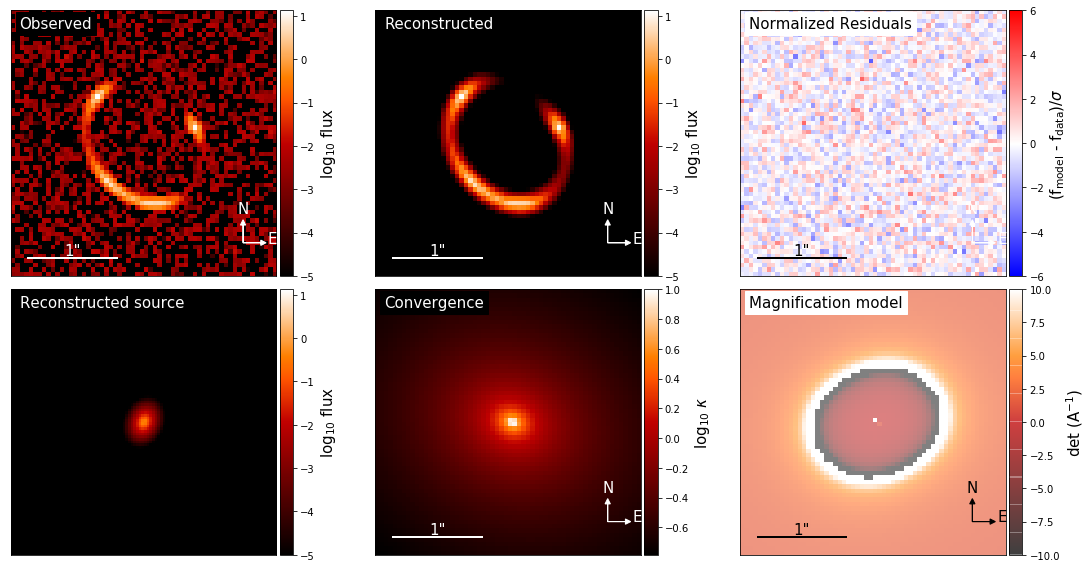

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:490: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


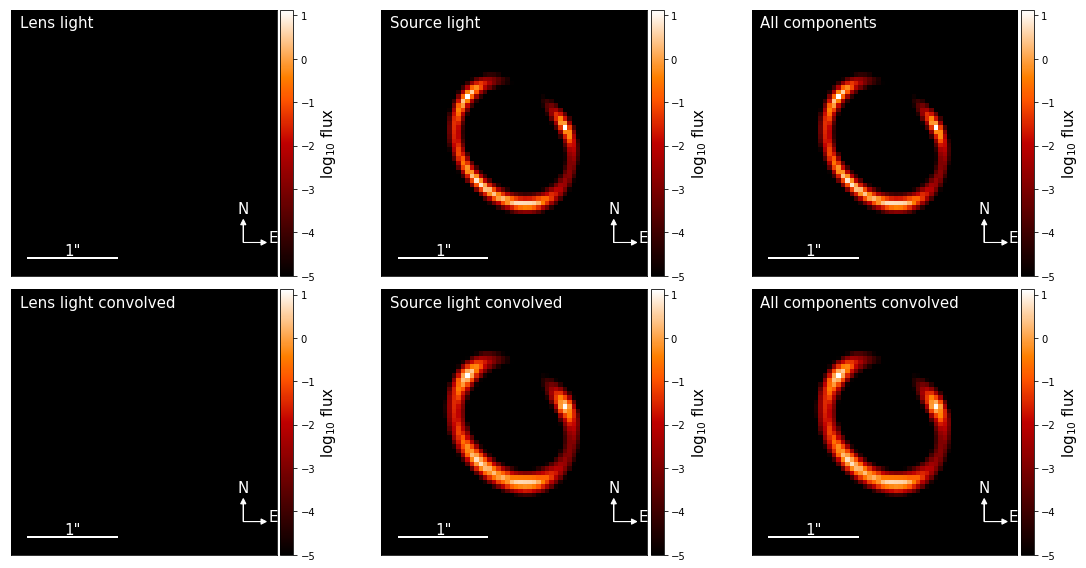

{'kwargs_lens': [{'theta_E': 0.6596723815778786, 'e1': 0.06087491001956077, 'e2': -0.034929195964456775, 'gamma': 1.9408508224830314, 'center_x': 0.050239267257521356, 'center_y': -0.000537136839523373}, {'gamma1': -0.006366986717764328, 'gamma2': -0.10351142190912002, 'ra_0': 0, 'dec_0': 0}, {'gamma1': 0.0043344721718429615, 'gamma2': -0.01731720526127008, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1568.2486777230945, 'R_sersic': 0.014927258551511719, 'n_sersic': 0.9940225553522481, 'e1': -0.09625050240197379, 'e2': 0.09685453640362915, 'center_x': 0.000531644622846528, 'center_y': -0.000180840755941558}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [7]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  16
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'gamma1_lens2', 'gamma2_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
number of evaluations in the MCMC process:  80000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


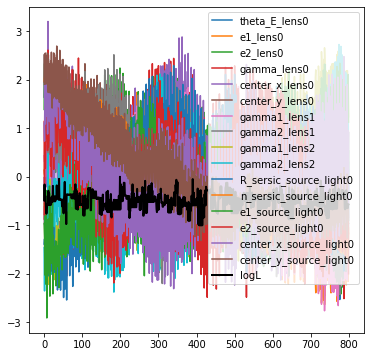

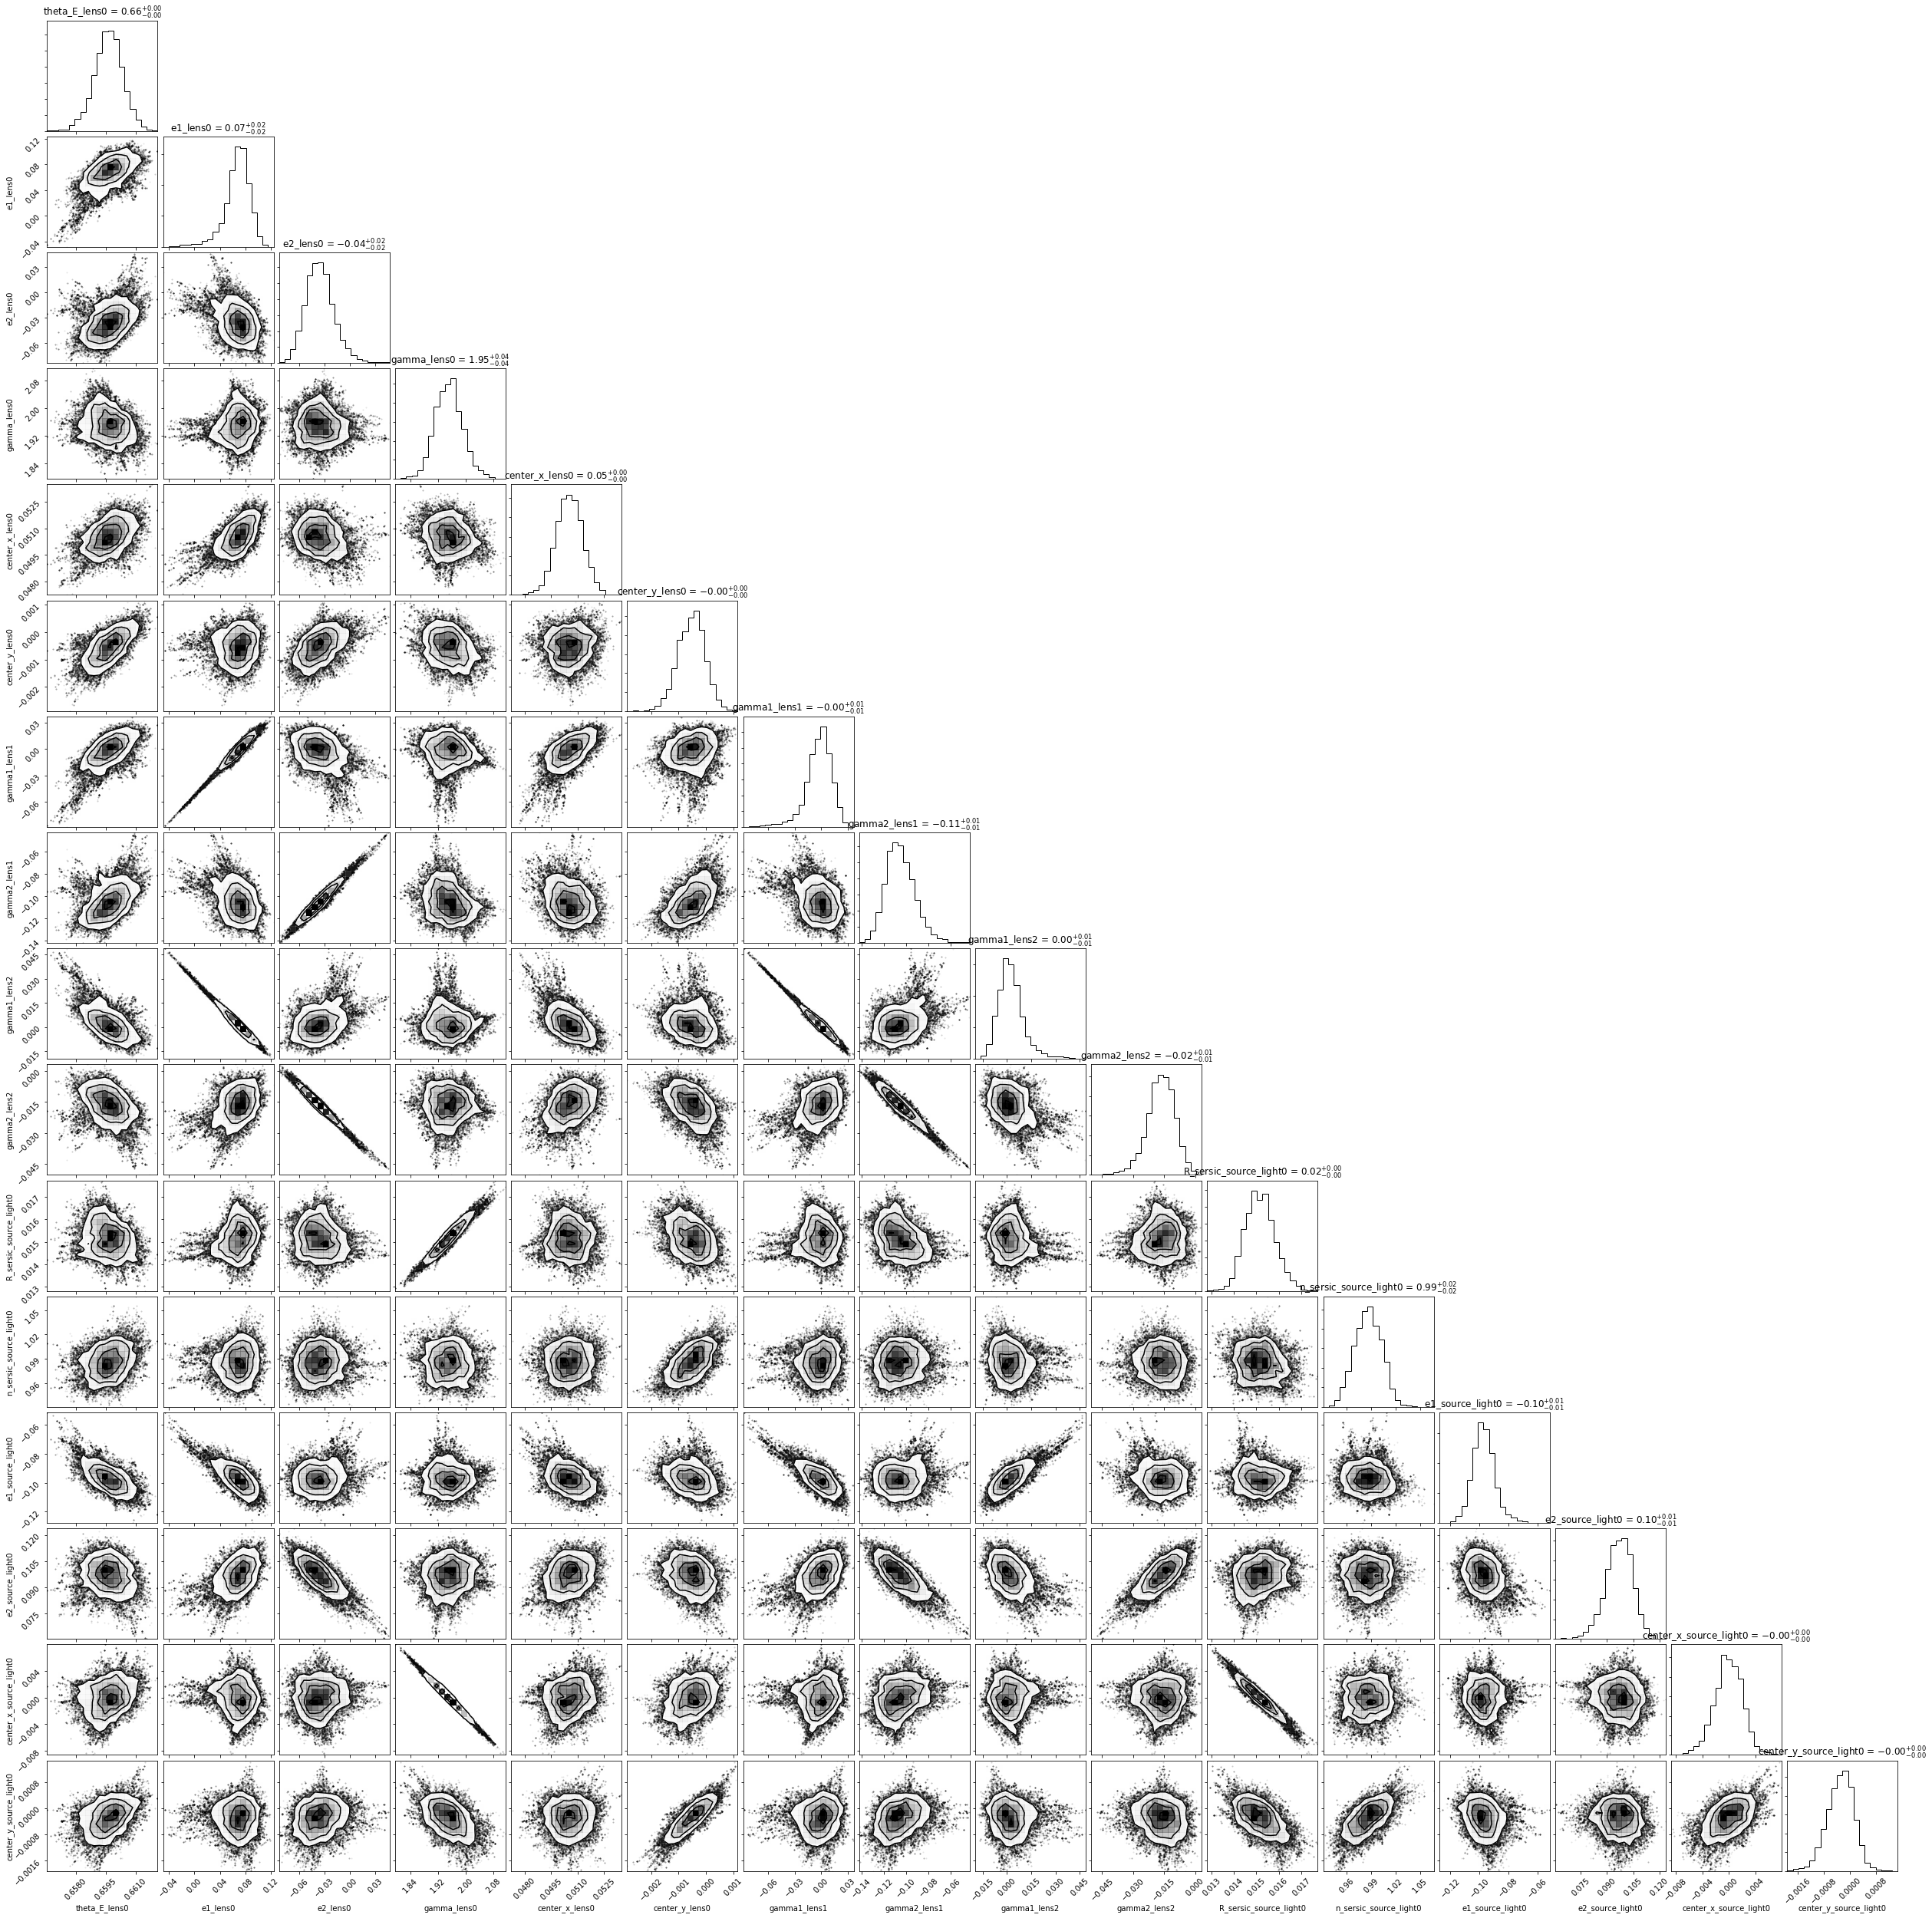

In [8]:
# the results of the MCMC chain, split in two corner plots

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc)
    #plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
    #plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)
    plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)